In [1]:
import torch
import os
import numpy as np
import sys
import time
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

sys.path.append("../")
from src.train import load_processed_data, format_data
from src.model import GRUSurrogate, LSTMSurrogate, TCNForecaster

from plot_utils import plot_temperature_sequences

## 1. Load data and model

In [31]:
run_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035"
data_dir = os.path.join(run_dir, "processed")
device = "cuda:0"

# Load and format data
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data(data_dir)
train_loader, val_loader, test_loader, G = format_data(X_train, y_train, X_val, y_val, X_test, y_test)

# Build model
#model = GRUSurrogate(n_gas=G).to(device)
model = LSTMSurrogate(n_gas=G, hidden=256, num_layers=2).to(device)
#model = TCNForecaster(n_gas=G, n_blocks=8, hidden=128, k=3).to(device)

model_dir = os.path.join(run_dir, "model_lstm_v1.pth")
model.load_state_dict(torch.load(model_dir, map_location=device, weights_only=False))

<All keys matched successfully>

## 2. Run evaluation of model

In [32]:
y_pred_list, y_target_list = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        y_pred = model(xb).cpu().numpy()
        y_target = yb.cpu().numpy()
        
        # Save the data
        y_pred_list.append(y_pred)
        y_target_list.append(y_target)

y_pred_numpy = np.concatenate(y_pred_list)
y_target_numpy = np.concatenate(y_target_list)

rmse = np.sqrt(mean_squared_error(y_target_numpy, y_pred_numpy))
r2   = r2_score(y_target_numpy, y_pred_numpy)
print(f"RMSE: {rmse}, R2: {r2}")

RMSE: 0.007095291793843853, R2: 0.9996724128723145


In [33]:
y_pred_numpy[:8]

array([0.75076914, 0.79107857, 0.8242731 , 0.856614  , 0.8858907 ,
       0.91381145, 0.9410058 , 0.96524525], dtype=float32)

In [34]:
y_target_numpy[:8]

array([0.7518406 , 0.79247546, 0.8253045 , 0.8562213 , 0.88463986,
       0.9126969 , 0.93922585, 0.9634345 ], dtype=float32)

In [35]:
y_target_numpy.reshape(-1, 61).T[:35,:]

array([[0.7518406 , 0.752033  , 0.75216234, ..., 0.75241464, 0.7520866 ,
        0.751709  ],
       [0.79247546, 0.7951083 , 0.79602677, ..., 0.7948948 , 0.7946903 ,
        0.7913155 ],
       [0.8253045 , 0.8331919 , 0.8356833 , ..., 0.8312482 , 0.8316047 ,
        0.82207817],
       ...,
       [1.668795  , 1.383703  , 1.4180156 , ..., 1.7169788 , 1.6485869 ,
        1.3092748 ],
       [1.6997275 , 1.3935778 , 1.4288439 , ..., 1.7360988 , 1.6621584 ,
        1.3117254 ],
       [1.730495  , 1.4035068 , 1.439449  , ..., 1.7552755 , 1.6750907 ,
        1.3140712 ]], shape=(35, 3000), dtype=float32)

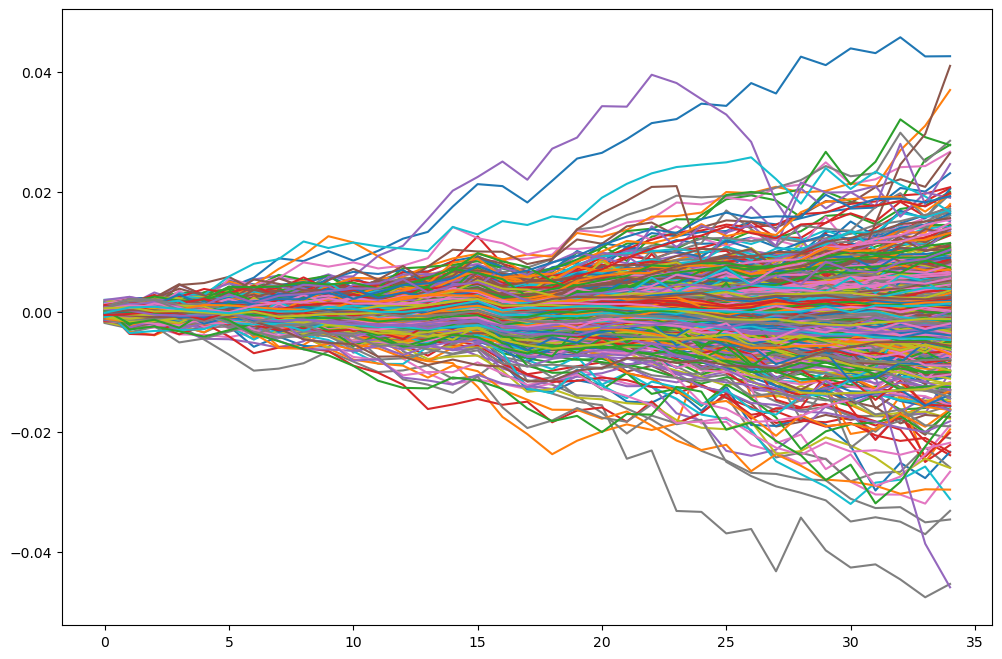

In [36]:
y_target_em_paths = y_target_numpy.reshape(-1, 61).T[:35,:]
y_pred_em_paths = y_pred_numpy.reshape(-1, 61).T[:35,:]

y_diff = y_target_em_paths - y_pred_em_paths

plt.figure(figsize=(12,8))
plt.plot(y_diff)
plt.show()

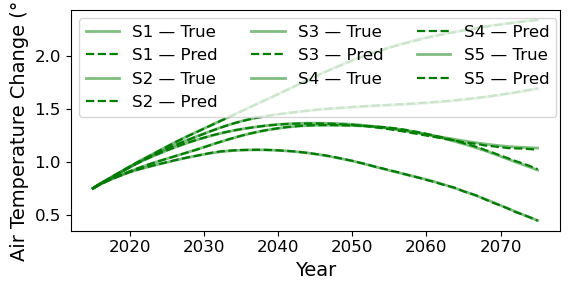

In [37]:
plot_temperature_sequences(y_target_numpy, y_pred_numpy, seq_len=61, n_samples=5, seed=11,
                   years=np.arange(2015, 2015+36+25), 
                   savepath="plots/test_seq_cicero_net.pdf")

## 4. Small speed test

In [29]:
def time_single_step_preds(model, data_loader, device="cuda", return_latency=False, warmup=True):

    model.eval().to(device)
    preds = []
    latencies = []

    if warmup:
        with torch.inference_mode():
            for batch in data_loader:
                xb = batch[0] if isinstance(batch, (tuple, list)) else batch
                xb = xb.to(device, non_blocking=True)
                _ = model(xb[:1])
                torch.cuda.synchronize()
                break

    with torch.inference_mode():
        for batch in data_loader:
            xb = batch[0] if isinstance(batch, (tuple, list)) else batch
            xb = xb.to(device, non_blocking=True)
            B = xb.shape[0]

            for i in range(B):
                x_i = xb[i:i+1]
                torch.cuda.synchronize()
                t0 = time.perf_counter()
                y_hat_i = model(x_i)
                t1 = time.perf_counter()

                latencies.append(t1 - t0)
                preds.append(float(y_hat_i.squeeze().detach().cpu().numpy()))

    preds = np.asarray(preds, dtype=float)
    if return_latency:
        return preds, np.asarray(latencies, dtype=float)
    return preds

In [30]:
# preds + per-call latencies (seconds)
preds, lat = time_single_step_preds(model, test_loader, device="cuda", return_latency=True)
print(f"mean latency = {lat.mean():.5f} s")

RuntimeError: DataLoader worker (pid(s) 630481, 630485) exited unexpectedly